In [1]:
import sys
sys.path.append('..')

In [2]:
from utils import dump_jsonl, load_jsonl

In [3]:
import pandas as pd

users = ["user1", "user2", "user3"]

def authority_to_eng(label):
    if label == 'B ให้เกียรติ':
        return "1. Respect"
    elif label == 'B ทำตัวปกติ':
        return "2. Normal"
    elif label == 'B ไม่ให้เกียรติกัน':
        return "3. Not respect"
    else:
        return None

def closeness_to_eng(label):
    if label == 'สนิทกันมาก':
        return "1. Very Close"
    elif label == 'สนิทกัน' or label == 'สนิท':
        return "2. Close"
    elif label == 'แค่คนรู้จักกัน':
        return "3. Know each other"
    elif label == 'ไม่รู้จักกัน':
        return "4. Don't know each other"
    elif label == 'ไม่ชอบหน้ากัน':
        return "5. Don't like each other"
        # return "4. Don't know each other"
    else:
        return None
    
    
def load_data(filename, column_name, fn=None):
    annotated = load_jsonl(filename)
    
    _df = []
    for row in annotated:
        if len(row["label"])==0:
            label = None
        else:
            if fn is None:
                label = row["label"][0]
            else:
                label = fn(row["label"][0])

        _df.append({
            "text": row["text"],
            "tweet": row["tweet"],
            column_name: label,
#             f"{column_name}_degree": to_degree(label)
        })
    
    return pd.DataFrame(_df)

## Closeness

In [4]:
clos_df = load_data(f"raw_data/annotated/v1.0/closeness_1.0/user0.jsonl", "closeness")
clos_df1 = clos_df[["text", "tweet"]]
clos_df = load_data(f"raw_data/annotated/v2.0/closeness_2.0/user0.jsonl", "closeness")
clos_df2 = clos_df[["text", "tweet"]]

clos_df = pd.concat([clos_df1, clos_df2])
clos_df = clos_df.drop_duplicates(subset=['text'])
len(clos_df)

Loaded 1000 records from raw_data/annotated/v1.0/closeness_1.0/user0.jsonl
Loaded 1857 records from raw_data/annotated/v2.0/closeness_2.0/user0.jsonl


2817

In [5]:
for uidx, u in enumerate(users):
    df1 = load_data(f"raw_data/annotated/v1.0/closeness_1.0/{u}.jsonl", "closeness", closeness_to_eng)
    df1.columns = ['text', 'tweet', f'closeness_{uidx+1}']
    
    df2 = load_data(f"raw_data/annotated/v2.0/closeness_2.0/{u}.jsonl", "closeness", closeness_to_eng)
    df2.columns = ['text', 'tweet', f'closeness_{uidx+1}']
    
    df = pd.concat([df1, df2])
    df = df.drop_duplicates(subset=['text'])
    df = df[['tweet', f'closeness_{uidx+1}']]
    
    clos_df = pd.merge(clos_df, df, on="tweet", how="left")
    print(len(clos_df))

Loaded 1000 records from raw_data/annotated/v1.0/closeness_1.0/user1.jsonl
Loaded 1857 records from raw_data/annotated/v2.0/closeness_2.0/user1.jsonl
2817
Loaded 1000 records from raw_data/annotated/v1.0/closeness_1.0/user2.jsonl
Loaded 1857 records from raw_data/annotated/v2.0/closeness_2.0/user2.jsonl
2817
Loaded 1000 records from raw_data/annotated/v1.0/closeness_1.0/user3.jsonl
Loaded 1857 records from raw_data/annotated/v2.0/closeness_2.0/user3.jsonl
2817


In [6]:
# clos_df.head()

In [7]:
data_type = []
closeness = []

for ridx, row in clos_df.iterrows():
    if row["closeness_1"]==row["closeness_2"] and row["closeness_2"]==row["closeness_3"]:
        data_type.append("gold")
        closeness.append(row["closeness_1"])
        
    elif row["closeness_1"]!=row["closeness_2"] and row["closeness_2"]!=row["closeness_3"] and row["closeness_1"]!=row["closeness_3"]:
        data_type.append("failed")
        closeness.append(None)
    else:
        data_type.append("silver")
        if row["closeness_1"]==row["closeness_2"]:
            closeness.append(row["closeness_1"])
        elif row["closeness_1"]==row["closeness_3"]:
            closeness.append(row["closeness_1"])
        elif row["closeness_2"]==row["closeness_3"]:
            closeness.append(row["closeness_2"])
        else:
            raise Exception("Unknow situation")
            
clos_df["data_type"] = data_type
clos_df["closeness"] = closeness
            

In [8]:
# clos_df

In [9]:
clos_df[["text", "data_type"]].groupby("data_type").count()

,text
data_type,
failed,435
gold,1189
silver,1193


In [10]:
# clos_df[clos_df["data_type"]=="failed"]

In [11]:
# print(clos_df.iloc[999]["text"])

In [12]:
print("Usable Records:", len(clos_df[clos_df["data_type"]!="failed"]))

Usable Records: 2382


<Axes: xlabel='closeness'>

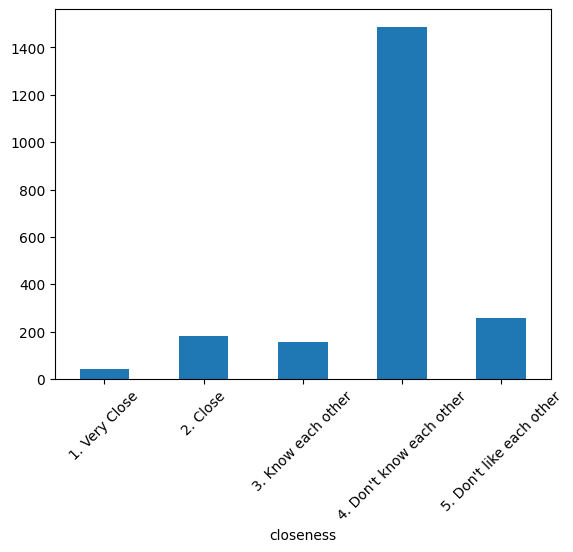

In [13]:
# clos_df["closeness"] = pd.Categorical(clos_df["closeness"], categories=[
#     "1. Very Close",
#     "2. Close",
#     "3. Know each other",
#     "4. Don't know each other",
#     "5. Don't like each other"
# ], ordered=True)

clos_df["closeness"].value_counts().sort_index().plot(kind="bar", rot=45)

In [14]:
clos_df[["text", "closeness"]].groupby("closeness").count()

,text
closeness,
1. Very Close,42
2. Close,180
3. Know each other,158
4. Don't know each other,1487
5. Don't like each other,257


## Authority

In [15]:
auth_df = load_data(f"raw_data/annotated/v1.0/authority_1.0/user0.jsonl", "authority")
auth_df1 = auth_df[["text", "tweet"]]

auth_df = load_data(f"raw_data/annotated/v2.0/authority_2.0/user0.jsonl", "authority")
auth_df2 = auth_df[["text", "tweet"]]


auth_df = pd.concat([auth_df1, auth_df2])

Loaded 1000 records from raw_data/annotated/v1.0/authority_1.0/user0.jsonl
Loaded 1857 records from raw_data/annotated/v2.0/authority_2.0/user0.jsonl


In [16]:
auth_df = auth_df.drop_duplicates(subset=['text'])
len(auth_df)

2817

In [17]:
for uidx, u in enumerate(['user1', 'user2', 'user3']):
    df1 = load_data(f"raw_data/annotated/v1.0/authority_1.0/{u}.jsonl", "authority", authority_to_eng)
    df1.columns = ['text', 'tweet', f'authority_{uidx+1}']
    
    df2 = load_data(f"raw_data/annotated/v2.0/authority_2.0/{u}.jsonl", "authority", authority_to_eng)
    df2.columns = ['text', 'tweet', f'authority_{uidx+1}']
    
    df = pd.concat([df1, df2])
    df = df.drop_duplicates(subset=['text'])
    df = df[['tweet', f'authority_{uidx+1}']]
    
    auth_df = pd.merge(auth_df, df, on="tweet", how="left")
    print(len(auth_df))

Loaded 1000 records from raw_data/annotated/v1.0/authority_1.0/user1.jsonl
Loaded 1857 records from raw_data/annotated/v2.0/authority_2.0/user1.jsonl
2817
Loaded 1000 records from raw_data/annotated/v1.0/authority_1.0/user2.jsonl
Loaded 1857 records from raw_data/annotated/v2.0/authority_2.0/user2.jsonl
2817
Loaded 1000 records from raw_data/annotated/v1.0/authority_1.0/user3.jsonl
Loaded 1857 records from raw_data/annotated/v2.0/authority_2.0/user3.jsonl
2817


In [18]:
# auth_df.count()

In [19]:
data_type = []
authority = []

for ridx, row in auth_df.iterrows():
    if row["authority_1"]==row["authority_2"] and row["authority_2"]==row["authority_3"]:
        data_type.append("gold")
        authority.append(row["authority_1"])
    elif row["authority_1"]!=row["authority_2"] and row["authority_2"]!=row["authority_3"] and row["authority_1"]!=row["authority_3"]:
        data_type.append("failed")
        authority.append(None)
    else:
        data_type.append("silver")
        if row["authority_1"]==row["authority_2"]:
            authority.append(row["authority_1"])
        elif row["authority_1"]==row["authority_3"]:
            authority.append(row["authority_1"])
        elif row["authority_2"]==row["authority_3"]:
            authority.append(row["authority_2"])
        else:
            print(row)
            raise Exception("Unknow situation")
            
auth_df["data_type"] = data_type
auth_df["authority"] = authority
            

In [20]:
auth_df[["text", "data_type"]].groupby("data_type").count()

,text
data_type,
failed,234
gold,1366
silver,1217


<Axes: xlabel='authority'>

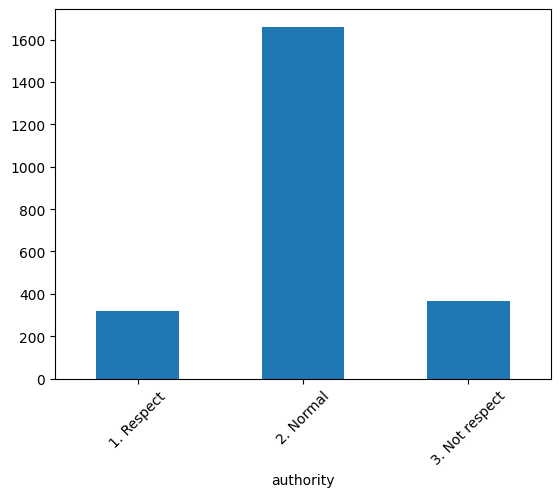

In [21]:
# auth_df["authority"].hist(xrot=45)
auth_df["authority"].value_counts().sort_index().plot(kind="bar", rot=45)

In [22]:
auth_df[["text", "authority"]].groupby("authority").count()

,text
authority,
1. Respect,319
2. Normal,1661
3. Not respect,364


In [23]:
# auth_df

## Export

In [24]:
A = clos_df[['text', 'tweet', 'closeness_1', 'closeness_2', 'closeness_3', 'closeness']]
B = auth_df[['tweet', 'authority_1', 'authority_2', 'authority_3', 'authority']]

In [25]:
M = pd.merge(A, B, on="tweet")

In [26]:
len(M)

2817

In [27]:
raw_data = load_jsonl("raw_data/unannotated/v1_unannotated.jsonl")

Loaded 2907 records from raw_data/unannotated/v1_unannotated.jsonl


In [28]:
annotated = []
for row in raw_data:
    cnt = M[M["tweet"]==row["tweet"]]
    if len(cnt)<=0:
        continue
    
    d = cnt.iloc[0].to_dict()
    for key in d:
        row[key] = d[key]
    
    if row["closeness"] is None and row["authority"] is None:
        continue

    annotated.append(row)

In [29]:
dump_jsonl("./raw_data/annotated/annotated.jsonl", annotated)

Wrote 2486 records to ./raw_data/annotated/annotated.jsonl


In [39]:
newdata = []
for row in annotated:
    messages = []
    for m in row["messages"]:
        messages.append({
            **m,
            "user_id": m["user_id"],
            "text": m["text"],
            "date_created": m["created_at"],
        })
        
    newdata.append({
        **row,
        "topic": None,
        "room_id": None,
        "messages": messages,
        "relationship": None,
        "closeness": row["closeness"],
        "closeness_1": row["closeness_1"],
        "closeness_2": row["closeness_2"],
        "closeness_3": row["closeness_3"],
        
        "authority": row["authority"],
        "authority_1": row["authority_1"],
        "authority_2": row["authority_2"],
        "authority_3": row["authority_3"],
    })
dump_jsonl("./annotated_conersations.jsonl", newdata)

Wrote 2486 records to ./annotated_conersations.jsonl


In [40]:
d = pd.DataFrame(annotated)

In [41]:
# d = d.dropna(subset=["closeness", "authority"], how="all")

In [42]:
d.count()

text              2486
label             2486
conersation_id    2486
messages          2486
tweet             2486
closeness_1       2437
closeness_2       1754
closeness_3       2457
closeness         2124
authority_1       2470
authority_2       2461
authority_3       1672
authority         2344
dtype: int64